Copyright (C) Microsoft Corporation.

# PreProcessing of Images for TF OD API  

In this notebook, we create tensorflow records for training and validation datasets, details can be found [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md)

In [1]:
import sys
import os
import io
import glob
from PIL import Image
import random
from lxml import etree
import contextlib2

from IPython.display import display
from utilities import create_dir
random.seed(4)

import tensorflow as tf
sys.path.append("../models/research/") # Modify to point to your tensorflow models directory
from object_detection.utils import dataset_util
from object_detection.utils import label_map_util
from object_detection.dataset_tools import tf_record_creation_util

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
# Annotated Images directory
data_dir = './annotated/'

# Label map path
label_map_path = './stockout_label_map.pbtxt'

# Outputs path
output_dir = 'outputdata'

In [3]:
create_dir(output_dir)

exists


In [4]:
# Read label dictionary
label_map_dict = label_map_util.get_label_map_dict(label_map_path)
class_name = 'stockout'

In [5]:
# Tensorflow record output paths
train_output_path = os.path.join(output_dir, 'stockout_train.record')
val_output_path = os.path.join(output_dir, 'stockout_val.record')

In [6]:
in_images = glob.glob(data_dir + '/**/'+ '*.jpg')
print("There are {} images.".format(len(in_images)))

There are 538 images.


In [7]:
in_images_sub = glob.glob(data_dir + '/**/**/'+ '*.jpg')
print("There are {} images.".format(len(in_images_sub)))

There are 239 images.


In [8]:
in_images = in_images + in_images_sub
print("There are {} images.".format(len(in_images)))

There are 777 images.


In [9]:
# in_images = glob.glob(data_dir + '*.jpg')
# print("There are {} images.".format(len(in_images)))

In [9]:
# train, validation  split
num_val = int(len(in_images) * 0.1)
num_train = len(in_images) - num_val 
print(num_train, num_val)

700 77


In [10]:
val_images = random.sample(in_images, num_val)
train_images = [img for img in in_images if img not in val_images]

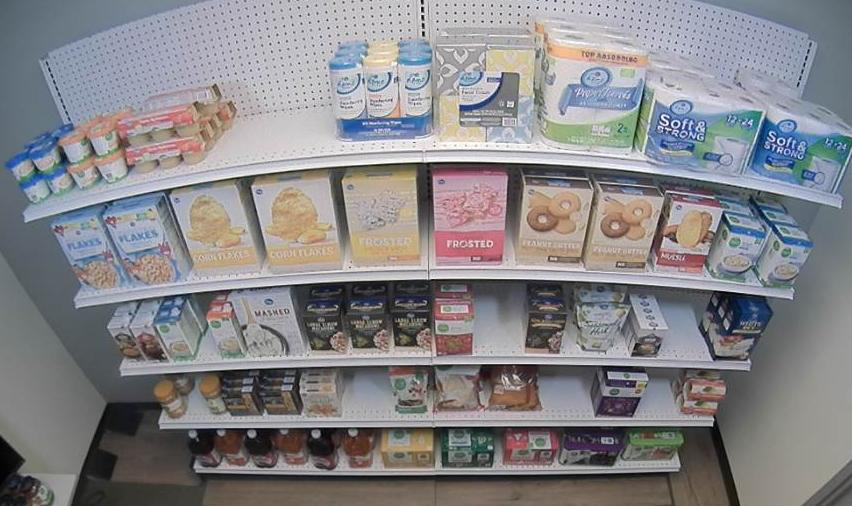

(852, 506)


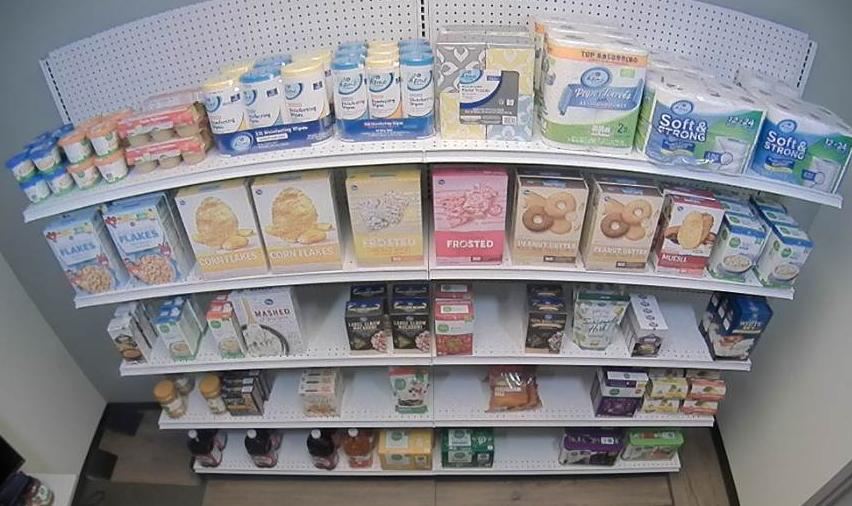

(852, 506)


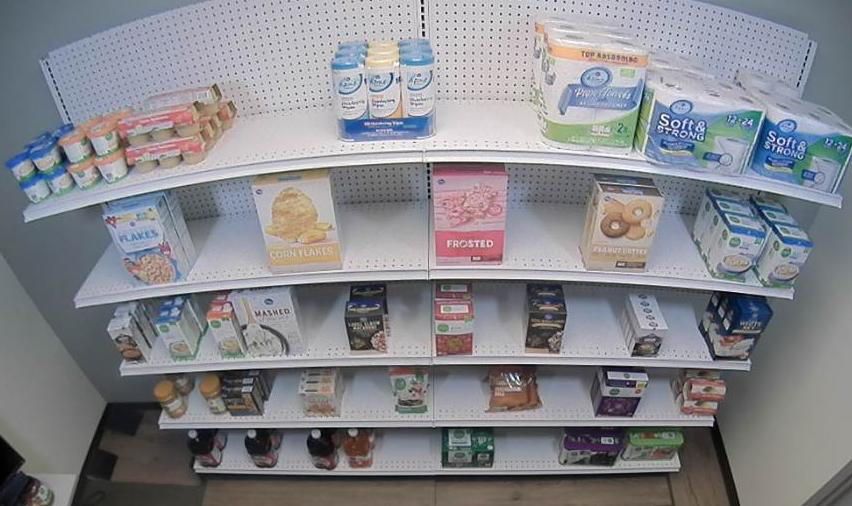

(852, 506)


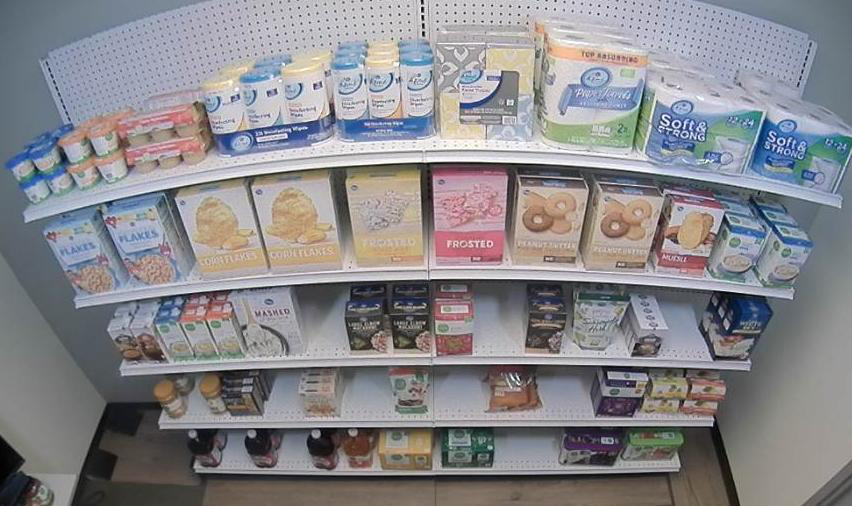

(852, 506)


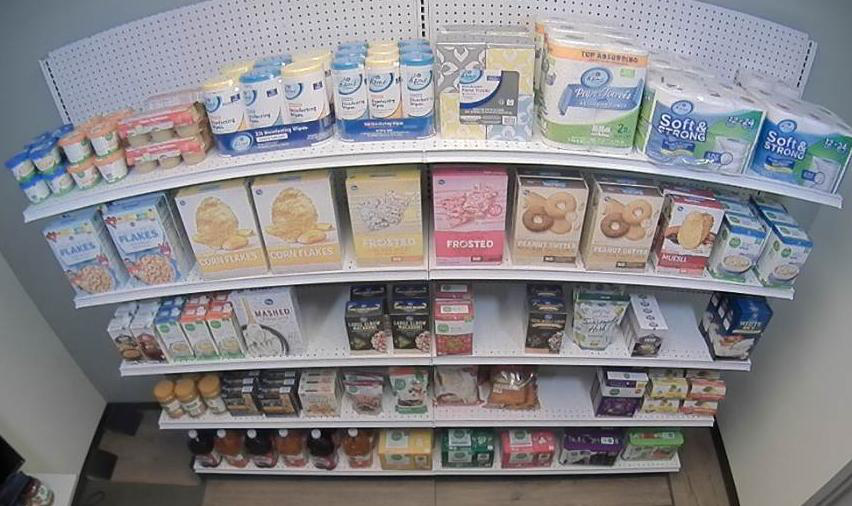

(852, 506)


In [11]:
# Sample of training images
for img_path in train_images[:5]:
    img = Image.open(img_path)
    display(img)
    print(img.size)

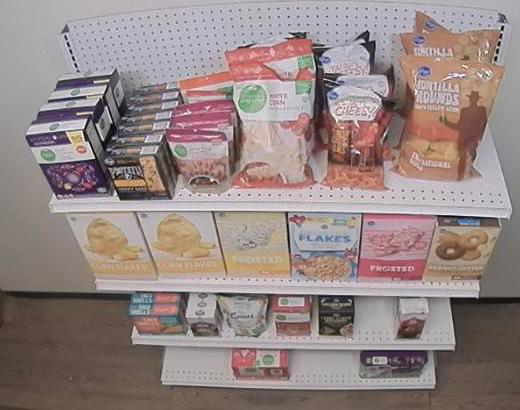

(520, 410)


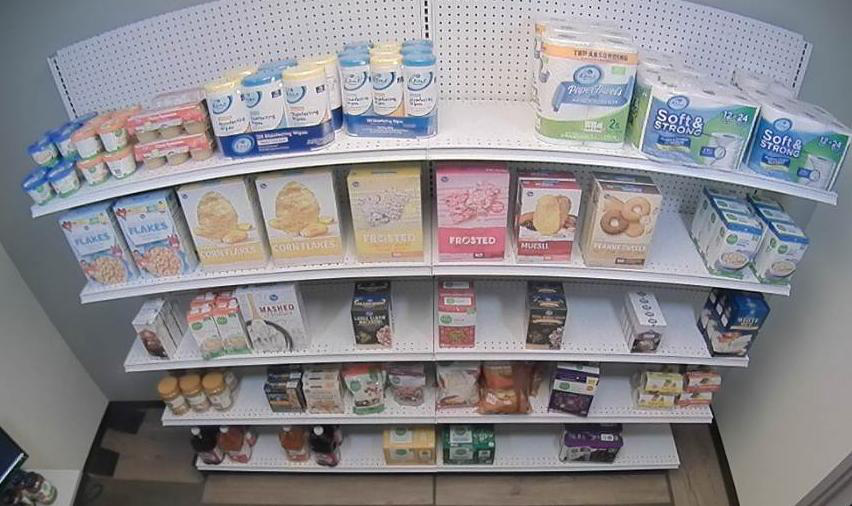

(852, 506)


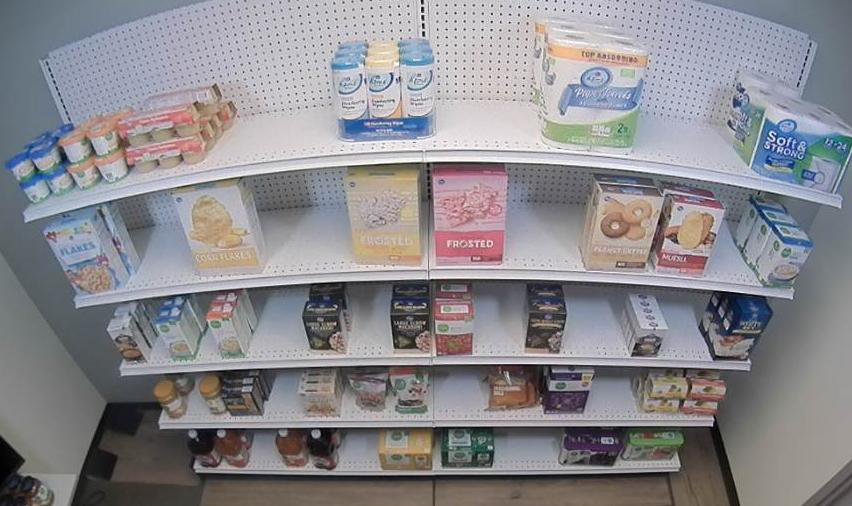

(852, 506)


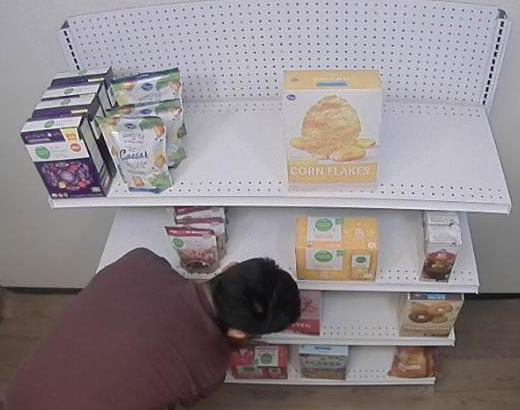

(520, 410)


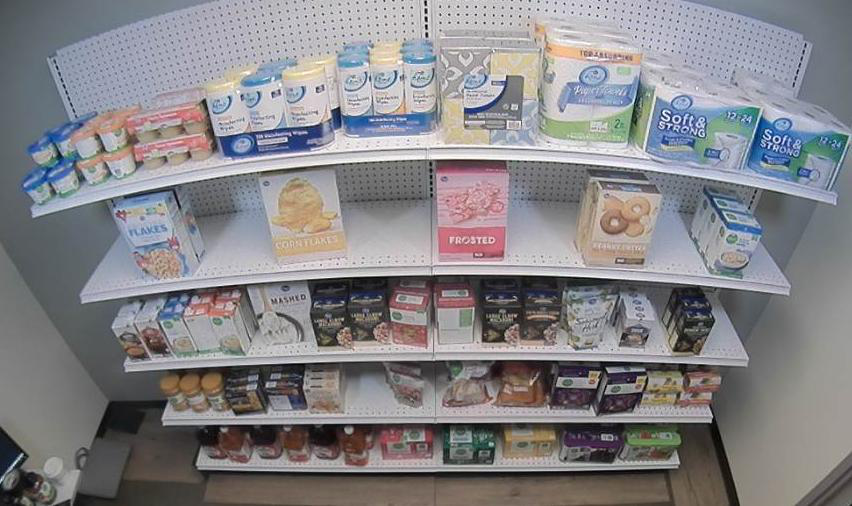

(852, 506)


In [12]:
# Sample of validation images
for img_path in val_images[:5]:
    img = Image.open(img_path)
    display(img)
    print(img.size)

In [13]:
def dict_to_tf_example(data, label_map_dict, img_path):
    
#     img_path = os.path.join(img_dir, data['filename'])
    with tf.gfile.GFile(img_path, 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    if image.format != 'JPEG':
        raise ValueError('Image format not JPEG')
    width = int(data['size']['width'])
    height = int(data['size']['height'])

    xmins = []
    ymins = []
    xmaxs = []
    ymaxs = []
    classes = []
    classes_text = []

    if 'object' in data:
        for obj in data['object']:
            xmin = float(obj['bndbox']['xmin'])
            xmax = float(obj['bndbox']['xmax'])
            ymin = float(obj['bndbox']['ymin'])
            ymax = float(obj['bndbox']['ymax'])

            xmins.append(xmin / width)
            ymins.append(ymin / height)
            xmaxs.append(xmax / width)
            ymaxs.append(ymax / height)
            classes_text.append(class_name.encode('utf8'))
            classes.append(label_map_dict[class_name])   
    feature_dict = {
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(data['filename'].encode('utf8')),
        'image/source_id': dataset_util.bytes_feature(data['filename'].encode('utf8')),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes)
    }

    example = tf.train.Example(features=tf.train.Features(feature=feature_dict))
    return example

In [14]:
def create_tf_record(output_filename, num_shards, label_map_dict, examples):
    
    with contextlib2.ExitStack() as tf_record_close_stack:
        output_tfrecords = tf_record_creation_util.open_sharded_output_tfrecords(tf_record_close_stack, output_filename, num_shards)

        for idx, example in enumerate(examples):
            if idx % 1 == 0:
                print('On image {} of {}'.format(idx, len(examples)))
            xml_path = os.path.join(example[:-4] + '.xml')
            if not os.path.exists(xml_path):
                print('Could not find {}, ignoring example'.format(xml_path))
                continue
            with tf.gfile.GFile(xml_path, 'r') as fid:
                xml_str = fid.read()
            xml = etree.fromstring(xml_str)
            data = dataset_util.recursive_parse_xml_to_dict(xml)['annotation']

            try:
                tf_example = dict_to_tf_example(data, label_map_dict, example)
                if tf_example:
                    shard_idx = idx % num_shards
                    output_tfrecords[shard_idx].write(tf_example.SerializeToString())
            except ValueError:
                print('Invalid example: {}, ignoring.'.format(xml_path))

In [15]:
# Create tensorflow records for training
create_tf_record(train_output_path, 2, label_map_dict, train_images)

On image 0 of 700
On image 1 of 700
On image 2 of 700
On image 3 of 700
On image 4 of 700
On image 5 of 700
On image 6 of 700
On image 7 of 700
On image 8 of 700
On image 9 of 700
On image 10 of 700
On image 11 of 700
On image 12 of 700
On image 13 of 700
On image 14 of 700
On image 15 of 700
On image 16 of 700
On image 17 of 700
On image 18 of 700
On image 19 of 700
On image 20 of 700
On image 21 of 700
On image 22 of 700
On image 23 of 700
On image 24 of 700
On image 25 of 700
On image 26 of 700
On image 27 of 700
On image 28 of 700
On image 29 of 700
On image 30 of 700
On image 31 of 700
On image 32 of 700
On image 33 of 700
On image 34 of 700
On image 35 of 700
On image 36 of 700
On image 37 of 700
On image 38 of 700
On image 39 of 700
On image 40 of 700
On image 41 of 700
On image 42 of 700
On image 43 of 700
On image 44 of 700
On image 45 of 700
On image 46 of 700
On image 47 of 700
On image 48 of 700
On image 49 of 700
On image 50 of 700
On image 51 of 700
On image 52 of 700
On 

On image 568 of 700
On image 569 of 700
On image 570 of 700
On image 571 of 700
On image 572 of 700
On image 573 of 700
On image 574 of 700
On image 575 of 700
On image 576 of 700
On image 577 of 700
On image 578 of 700
On image 579 of 700
On image 580 of 700
On image 581 of 700
On image 582 of 700
On image 583 of 700
On image 584 of 700
On image 585 of 700
On image 586 of 700
On image 587 of 700
On image 588 of 700
On image 589 of 700
On image 590 of 700
On image 591 of 700
On image 592 of 700
On image 593 of 700
On image 594 of 700
On image 595 of 700
On image 596 of 700
On image 597 of 700
On image 598 of 700
On image 599 of 700
On image 600 of 700
On image 601 of 700
On image 602 of 700
On image 603 of 700
On image 604 of 700
On image 605 of 700
On image 606 of 700
On image 607 of 700
On image 608 of 700
On image 609 of 700
On image 610 of 700
On image 611 of 700
On image 612 of 700
On image 613 of 700
On image 614 of 700
On image 615 of 700
On image 616 of 700
On image 617 of 700


In [16]:
 # Create tensorflow records for validation
create_tf_record(val_output_path, 1, label_map_dict, val_images)

On image 0 of 77
On image 1 of 77
On image 2 of 77
On image 3 of 77
On image 4 of 77
On image 5 of 77
On image 6 of 77
On image 7 of 77
On image 8 of 77
On image 9 of 77
On image 10 of 77
On image 11 of 77
On image 12 of 77
On image 13 of 77
On image 14 of 77
On image 15 of 77
On image 16 of 77
On image 17 of 77
On image 18 of 77
On image 19 of 77
On image 20 of 77
On image 21 of 77
On image 22 of 77
On image 23 of 77
On image 24 of 77
On image 25 of 77
On image 26 of 77
On image 27 of 77
On image 28 of 77
On image 29 of 77
On image 30 of 77
On image 31 of 77
On image 32 of 77
On image 33 of 77
On image 34 of 77
On image 35 of 77
On image 36 of 77
On image 37 of 77
On image 38 of 77
On image 39 of 77
On image 40 of 77
On image 41 of 77
On image 42 of 77
On image 43 of 77
On image 44 of 77
On image 45 of 77
On image 46 of 77
On image 47 of 77
On image 48 of 77
On image 49 of 77
On image 50 of 77
On image 51 of 77
On image 52 of 77
On image 53 of 77
On image 54 of 77
On image 55 of 77
On

Next, you can move to training the model.